In [59]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from matplotlib import transforms
import networkx as nx
from matplotlib.gridspec import GridSpec


import os
import sys
from importlib import reload

# local imports 
import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
reload(pcu)
reload(binning)
reload(filters)

<module 'filters' from '/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/filters.py'>

In [3]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [4]:
def loadRawContactDirectory(dirpath, filetags, verbose=True):
    """A function to load a directory of contact tables"""
    results = {}
    for runId in filetags:
        df = pcu.loadContactTable(dirpath, runId)
        
        if verbose:
            print(f"{runId=} {df.shape=}")
        
        results[runId] = df
    return results
    
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
filetags = [f"run0{x}" for x in range(1, 8)]
# filetags = [f"run0{x}" for x in range(1, 2)]
rawCells = loadRawContactDirectory(dirpath, filetags)

print(f"{rawCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run03' df.shape=(18685242, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
rawCells.keys()=dict_keys(['run01', 'run02', 'run03', 'run04', 'run05', 'run06', 'run07'])


In [5]:
rawCells['run01'].columns

Index(['read_name', 'read_length', 'read_idx', 'contact_is_direct',
       'contact_is_cis', 'contact_read_distance', 'contact_genome_distance',
       'contact_fragment_adjacent', 'contact_fragment_distance',
       'haplotype_pair_type', 'align1_align_idx', 'align1_chrom',
       'align1_start', 'align1_end', 'align1_strand', 'align1_mapping_quality',
       'align1_align_score', 'align1_align_base_qscore', 'align1_phase_set',
       'align1_phase_qual', 'align1_haplotype', 'align1_fragment_id',
       'align1_fragment_start', 'align1_fragment_end', 'align2_align_idx',
       'align2_chrom', 'align2_start', 'align2_end', 'align2_strand',
       'align2_mapping_quality', 'align2_align_score',
       'align2_align_base_qscore', 'align2_phase_set', 'align2_haplotype',
       'align2_fragment_id', 'align2_fragment_start', 'align2_fragment_end',
       'batch_id'],
      dtype='object')

In [111]:
reload(pcu)
reload(binning)
reload(filters)
    

def runAllFilters(cells, assembly, chromosome=None, verbose=True):
    """A function to filter all cells """
    
    results = {}
    
    for runId, df in cells.items():
        
        cf = cells[runId].copy()
    
        if chromosome is not None:
            cf = filters.chromosomalFilter(cf, assembly)
            cf = filters.removeYChrom(cf)
            cf = filters.filterChomosome(cf, chromosome)
            
        # merge the assmembly info
        cf = pcu.mergeAssembly(cf, assembly)
        
        if verbose:
            print("------------------------------")
            print(f"{runId=}")
    
        cf = filters.adjacentContactFilter(cf)
        cf = filters.selfLoopFilter(cf)
        cf = filters.mapQFilter(cf, lowerBound=30, upperBound=250)
        cf = filters.distalContactFilter(cf)
        cf = filters.closeContactFilter(cf)
        cf = filters.duplicateContactFilter(cf, retain=1)
        cf = filters.ligationProductFilter(cf, nProducts=4, verbose=False)
        cf = filters.establishContactSupport(cf, 
                                             radiusThreshold=1000000, 
                                             nContacts=3, 
                                             readSupport=False, 
                                             nReads=3,
                                             method=2)
        cf = filters.supportedContactFilter(cf, readSupport=False)
        
        if verbose:
            print(f"{cf.shape=}")
            print("-- -- --")
            res = pcu.getSummary(cf)
            pcu.printSummary(res)
            print()
            
        results[runId] = cf
        
    return results
    

filteredCells = runAllFilters(rawCells,
                              assembly, 
                              chromosome='NC_000068.8', 
                              verbose=True)  

print(f"{filteredCells.keys()=}")

------------------------------
runId='run01'
cf.shape=(5109, 64)
-- -- --
Total Reads 3539 (1.000)
Singletons 2552 (0.721)
Pairs 641 (0.181)
Multiway 346 (0.098)
-- -- --
Total Contacts 5109 (1.000)
cis Contacts 5109 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 5109 (1.000)
Direct Contacts 5109 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
runId='run02'
cf.shape=(2501, 64)
-- -- --
Total Reads 1840 (1.000)
Singletons 1402 (0.762)
Pairs 300 (0.163)
Multiway 138 (0.075)
-- -- --
Total Contacts 2501 (1.000)
cis Contacts 2501 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 2501 (1.000)
Direct Contacts 2501 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
runId='run03'
cf.shape=(356, 64)
-- -- --
Total Reads 246 (1.000)
Singletons 182 (0.740)
Pairs 41 (0.167)
Multiway 23 (0.093)
-- -- --
Total Contacts 356 (1.000)
cis Contacts 356 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 356 (1.000)
Direct Contacts 356 (1.000)
Ind

# make interaction networks

In [208]:
reload(pcu)
reload(binning)

chomosome = 2
chromLength = assembly.loc[assembly['Chromosome'] == str(chomosome), 'Total length'].values[0]

resolution = 1000000 # 1mb scale
chromBins = binning.getBins(chromLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

matrices = {}

for runId, data in filteredCells.items():
    print(f"{runId=}")
    
    chrom = binning.chromosomeBinData(data, 
                                     chromBins, 
                                     label1=label1, 
                                     label2=label2)
    
    A = pcu.getHic(chrom, chromBins, label1, label2)
    print(f"{A.shape=}")
    print(f"{np.max(A)=}")
    matrices[runId] = A
    
    print()
    
print(f"{matrices.keys()}")

runId='run01'
A.shape=(182, 182)
np.max(A)=2.0

runId='run02'
A.shape=(182, 182)
np.max(A)=2.0

runId='run03'
A.shape=(182, 182)
np.max(A)=2.0

runId='run04'
A.shape=(182, 182)
np.max(A)=2.0

runId='run05'
A.shape=(182, 182)
np.max(A)=2.0

runId='run06'
A.shape=(182, 182)
np.max(A)=2.0

runId='run07'
A.shape=(182, 182)
np.max(A)=2.0

dict_keys(['run01', 'run02', 'run03', 'run04', 'run05', 'run06', 'run07'])


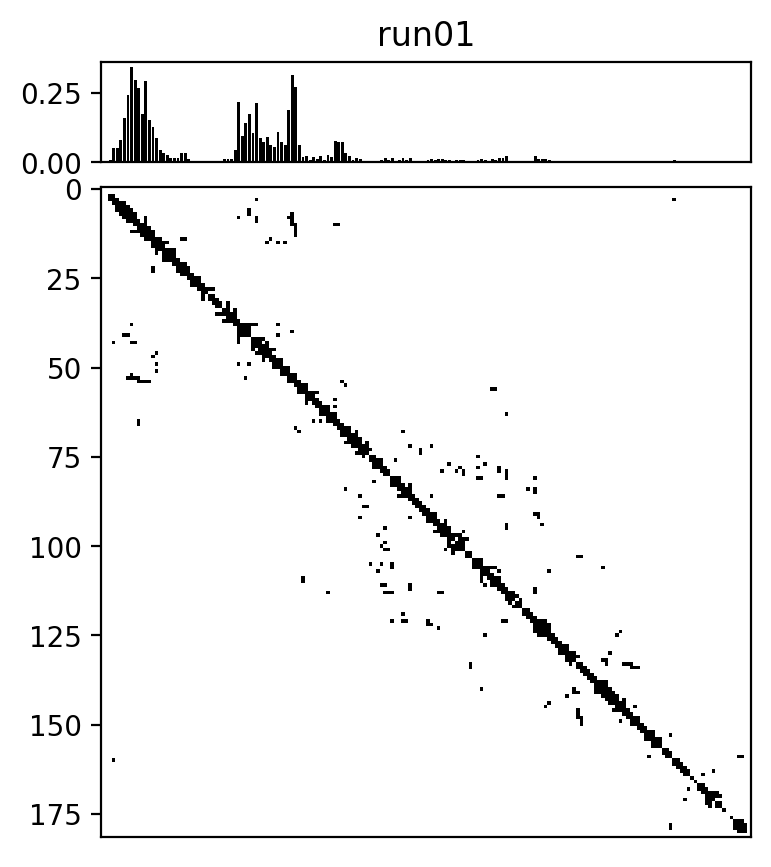

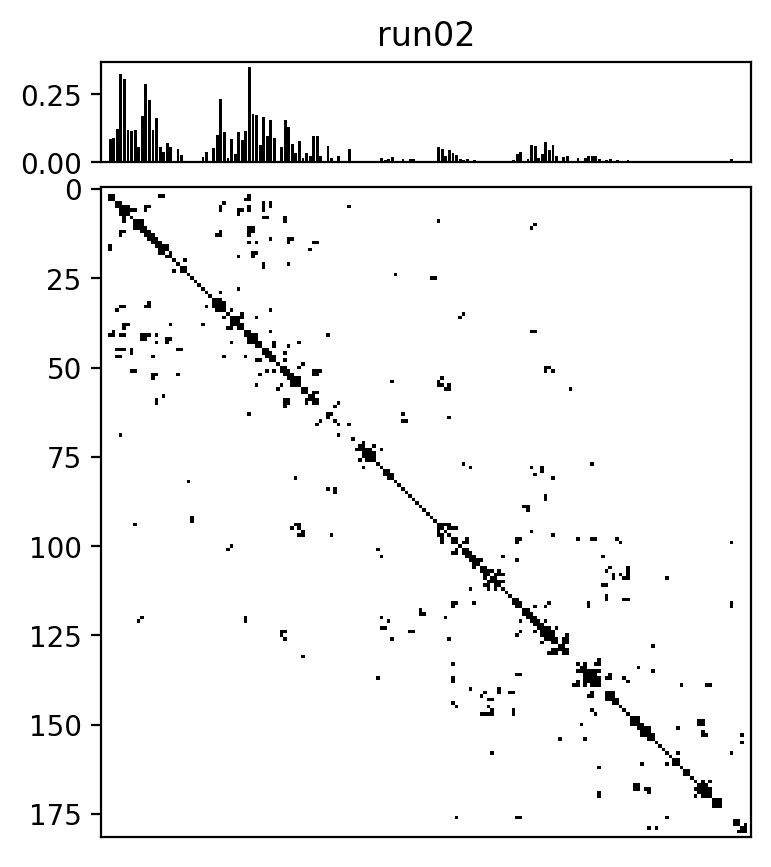

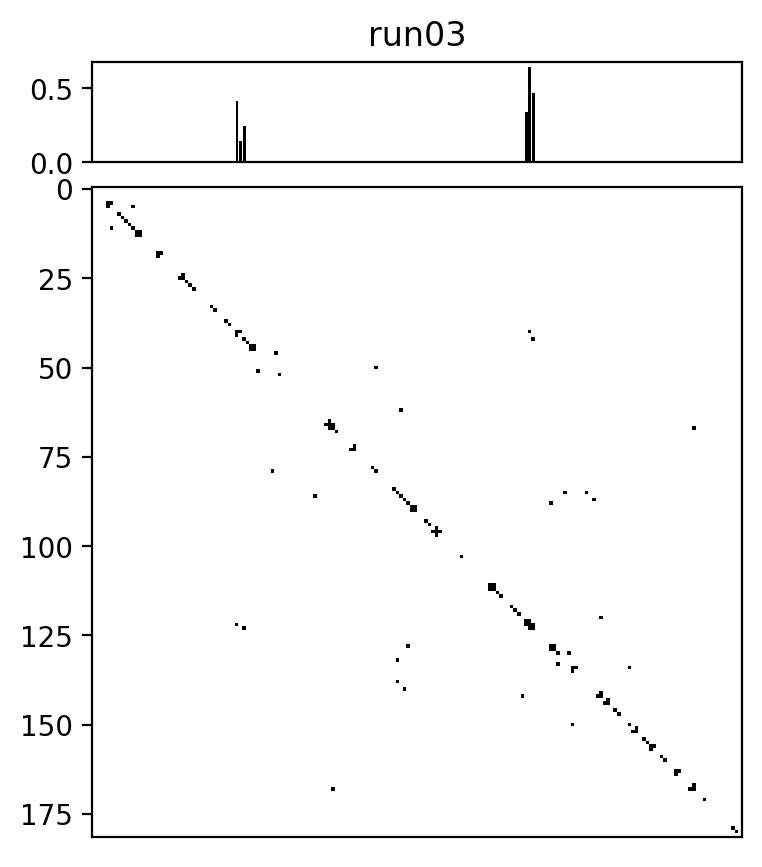

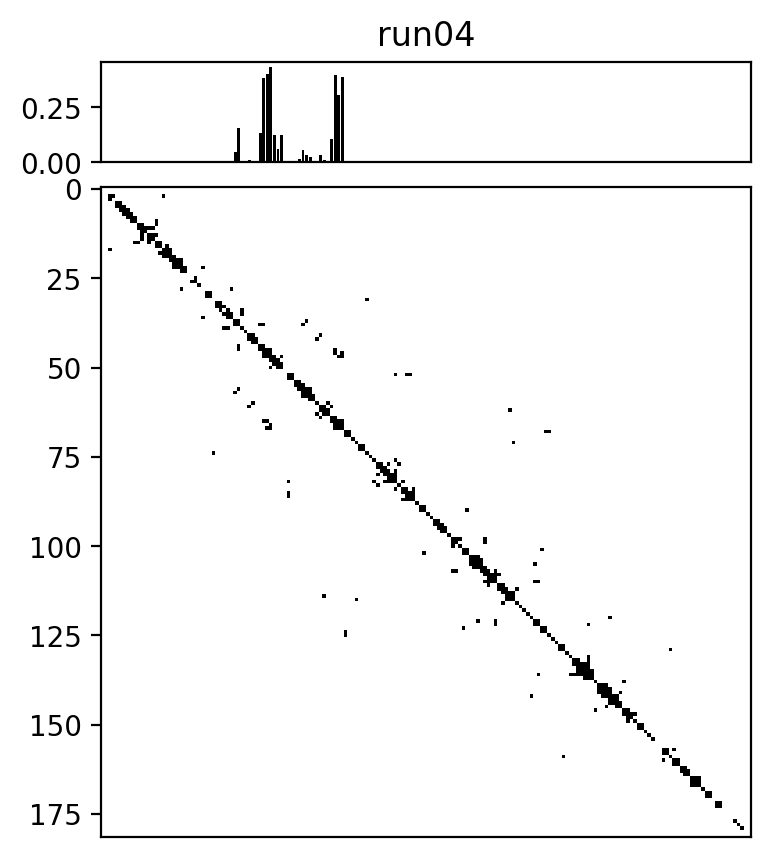

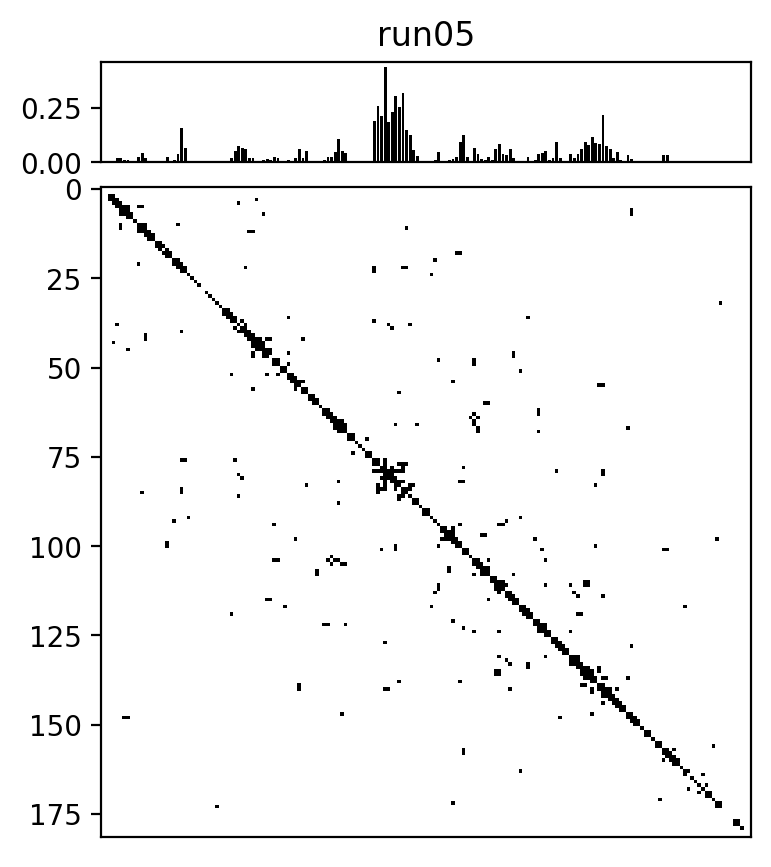

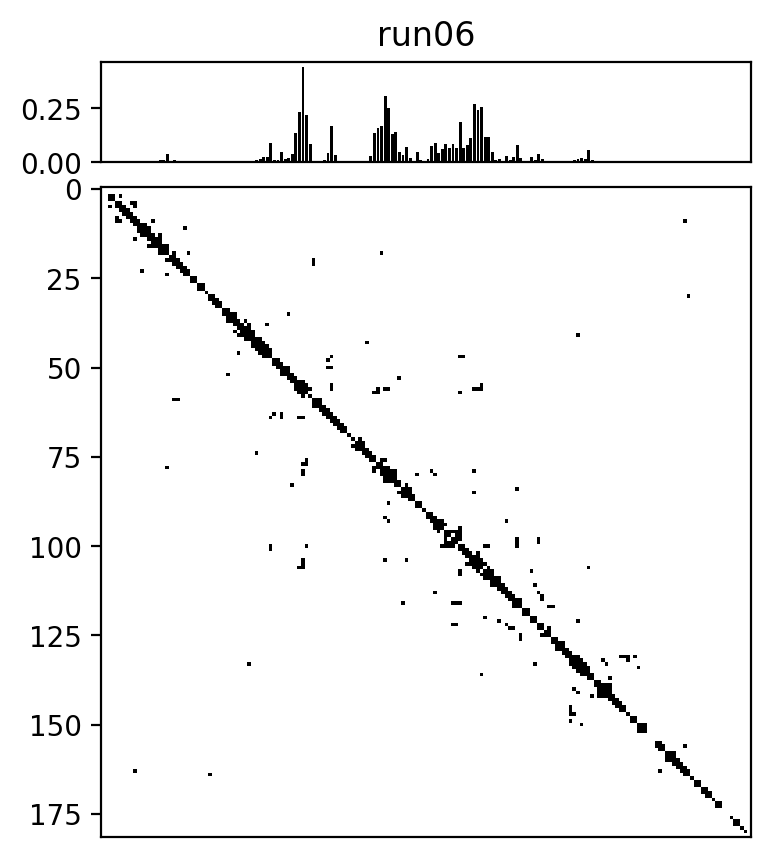

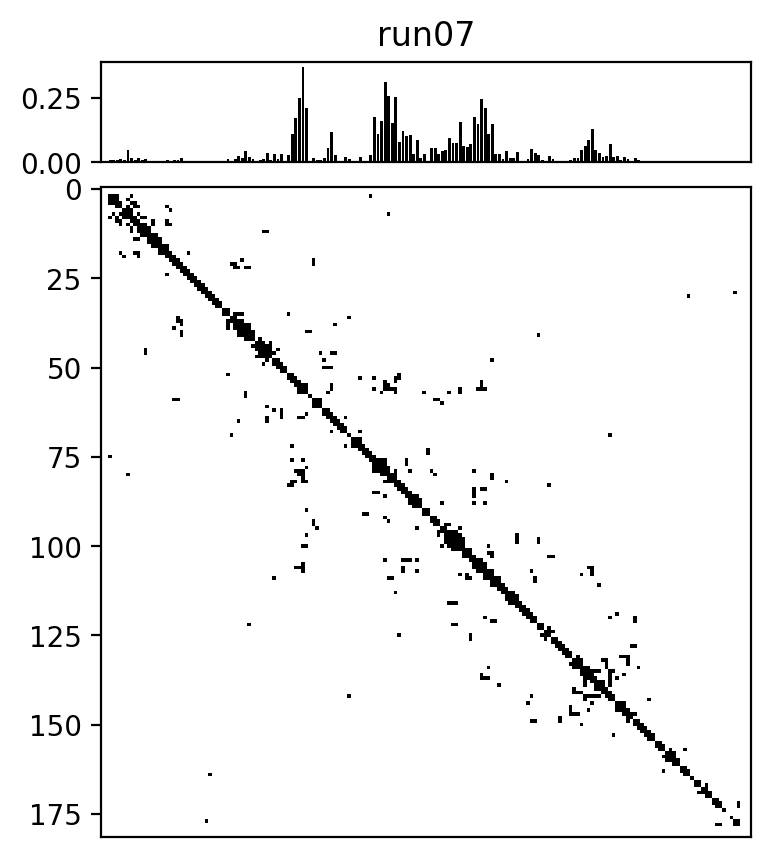

In [113]:
%matplotlib inline

plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 7

for runId, A in matrices.items():
    
    # binary representation
    Abinary = np.where(A > 0, 1, 0)
    
    G = nx.from_numpy_array(A)
    cent = nx.eigenvector_centrality(G, max_iter=1000)
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.025

    hicPlotSize = [left, bottom, width, height]
    centralityPlotSize = [left, bottom + height + spacing, width, 0.1]
    
    # start with a square Figure
    fig = plt.figure(figsize=(5, 5))

    ax1 = fig.add_axes(hicPlotSize)
    ax1.imshow(Abinary, cmap='binary')
    
    ax2 = fig.add_axes(centralityPlotSize, sharex=ax1)
    ax2.bar(cent.keys(), cent.values(), color='k')
    ax2.set_title(runId)
    ax2.set_xticks([])

    plt.show()

# Psuedobulk

[]

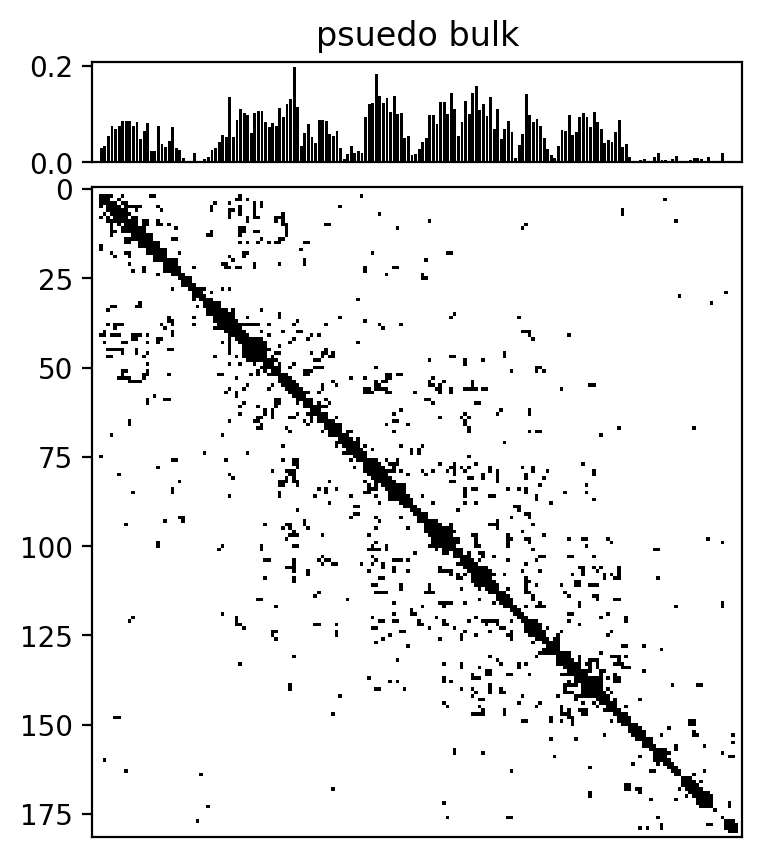

In [114]:
psuedoBulk = np.zeros((matrices['run01'].shape))

for runId, A in matrices.items():
    psuedoBulk = psuedoBulk + A
    

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

binaryBulk = np.where(psuedoBulk > 0, 1, 0)


G = nx.from_numpy_array(binaryBulk)
cent = nx.eigenvector_centrality(G, max_iter=1000)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.025


hicPlotSize = [left, bottom, width, height]
centralityPlotSize = [left, bottom + height + spacing, width, 0.1]

# start with a square Figure
fig = plt.figure()

ax1 = fig.add_axes(hicPlotSize)
ax1.imshow(binaryBulk, cmap='binary')

ax2 = fig.add_axes(centralityPlotSize, sharex=ax1)
ax2.bar(cent.keys(), cent.values(), color='k')
ax2.set_title('psuedo bulk')
ax2.set_xticks([])

In [165]:

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5

# for runId, A in matrices.items():
    
#     plt.imshow(binaryBulk, 
#                cmap='binary', 
#                interpolation='none',
#                alpha=0.4)
    
#     binaryA = np.where(A > 0, 1, 0)
#     plt.imshow(binaryA, 
#                cmap='Reds', 
#                interpolation='none', 
#                alpha=0.6)
    
#     plt.title(runId)
#     plt.show()
    

# Centrality

ef.shape=(182, 8)


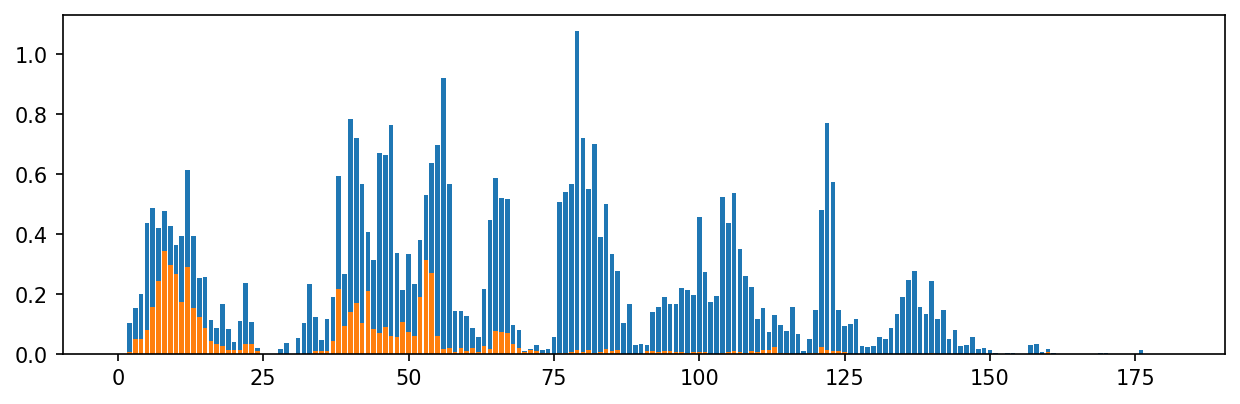

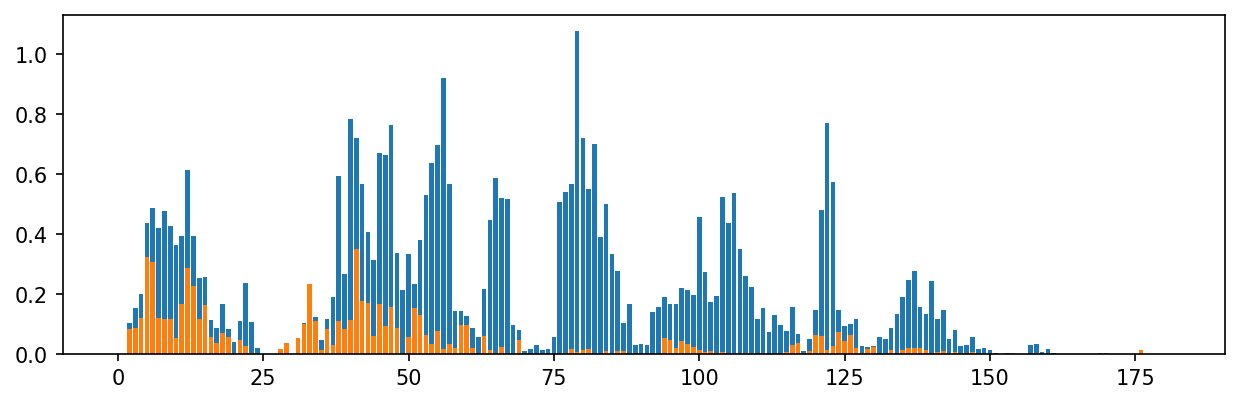

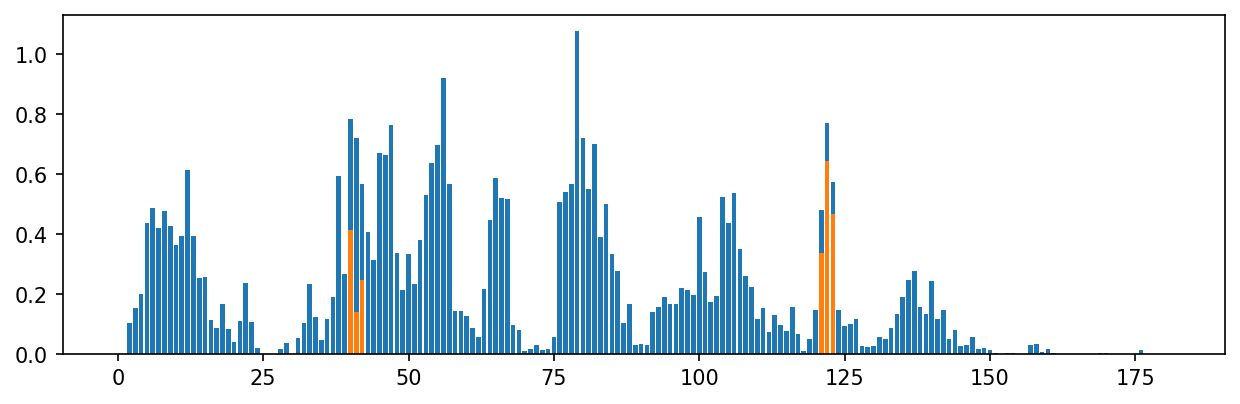

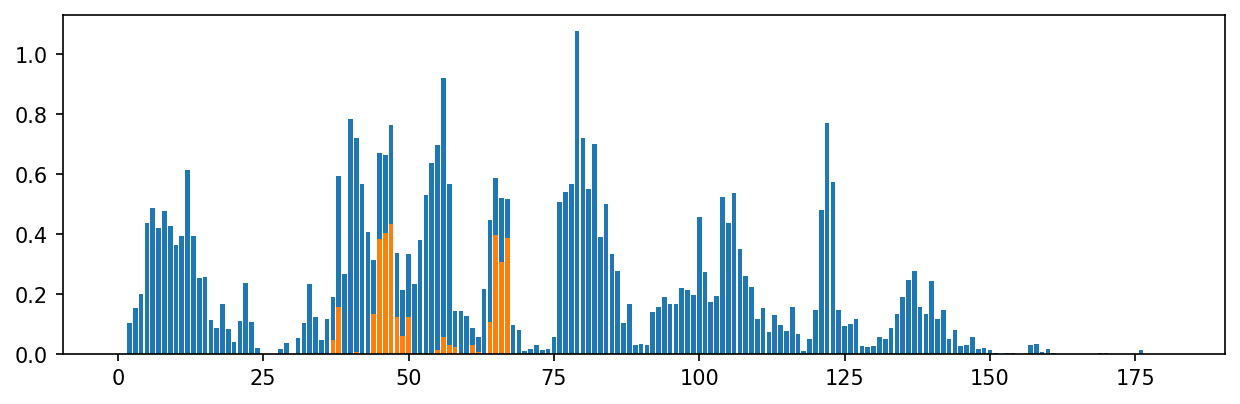

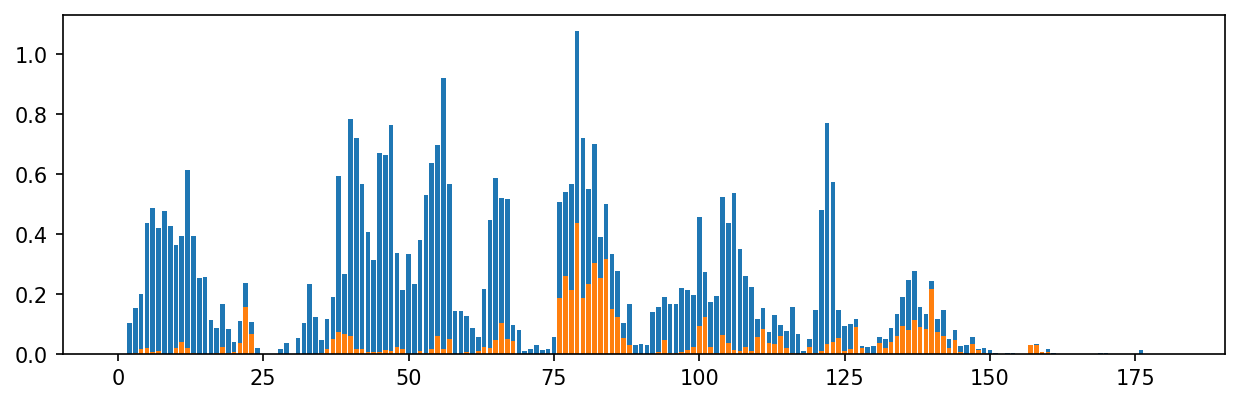

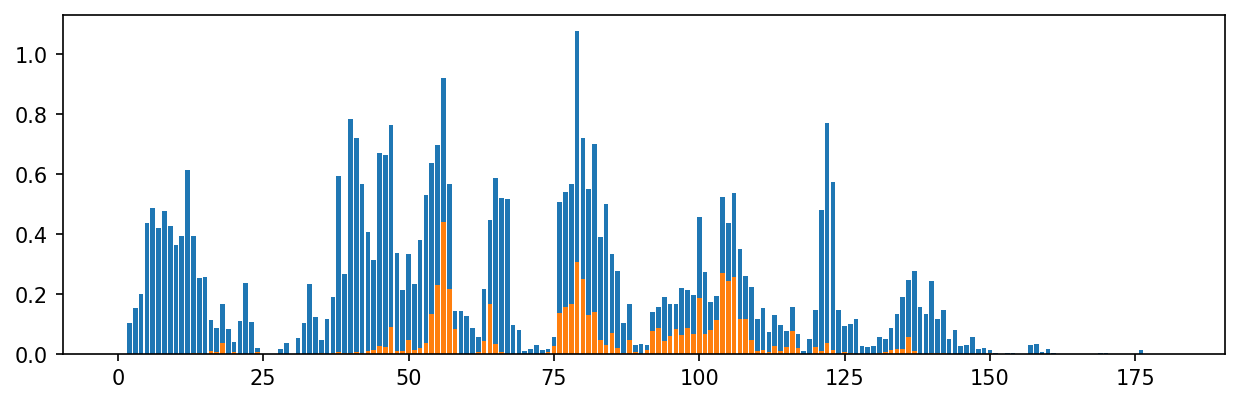

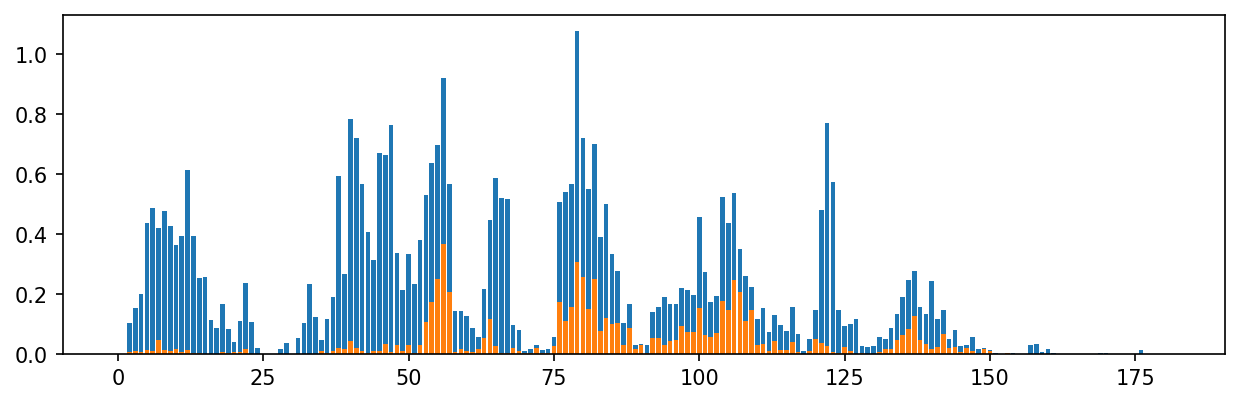

In [115]:
# centrality analysis


plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 10, 3

ef = pd.DataFrame(index=range(len(chromBins)))


for runId, A in matrices.items():
    G = nx.from_numpy_array(A)
    cent = nx.eigenvector_centrality(G, max_iter=1000)
    
    tmp = pd.Series(cent.values())
    tmp.name = runId
    ef = pd.concat([ef, tmp], axis=1)

    
ef.loc[:,'sum'] = ef.sum(numeric_only=True, axis=1)
    
print(f"{ef.shape=}")
ef.head()

for c in ef.columns:
    if not c == 'sum':
        plt.bar(ef.index, ef['sum'])
        plt.bar(ef.index, ef[c])
        plt.show()

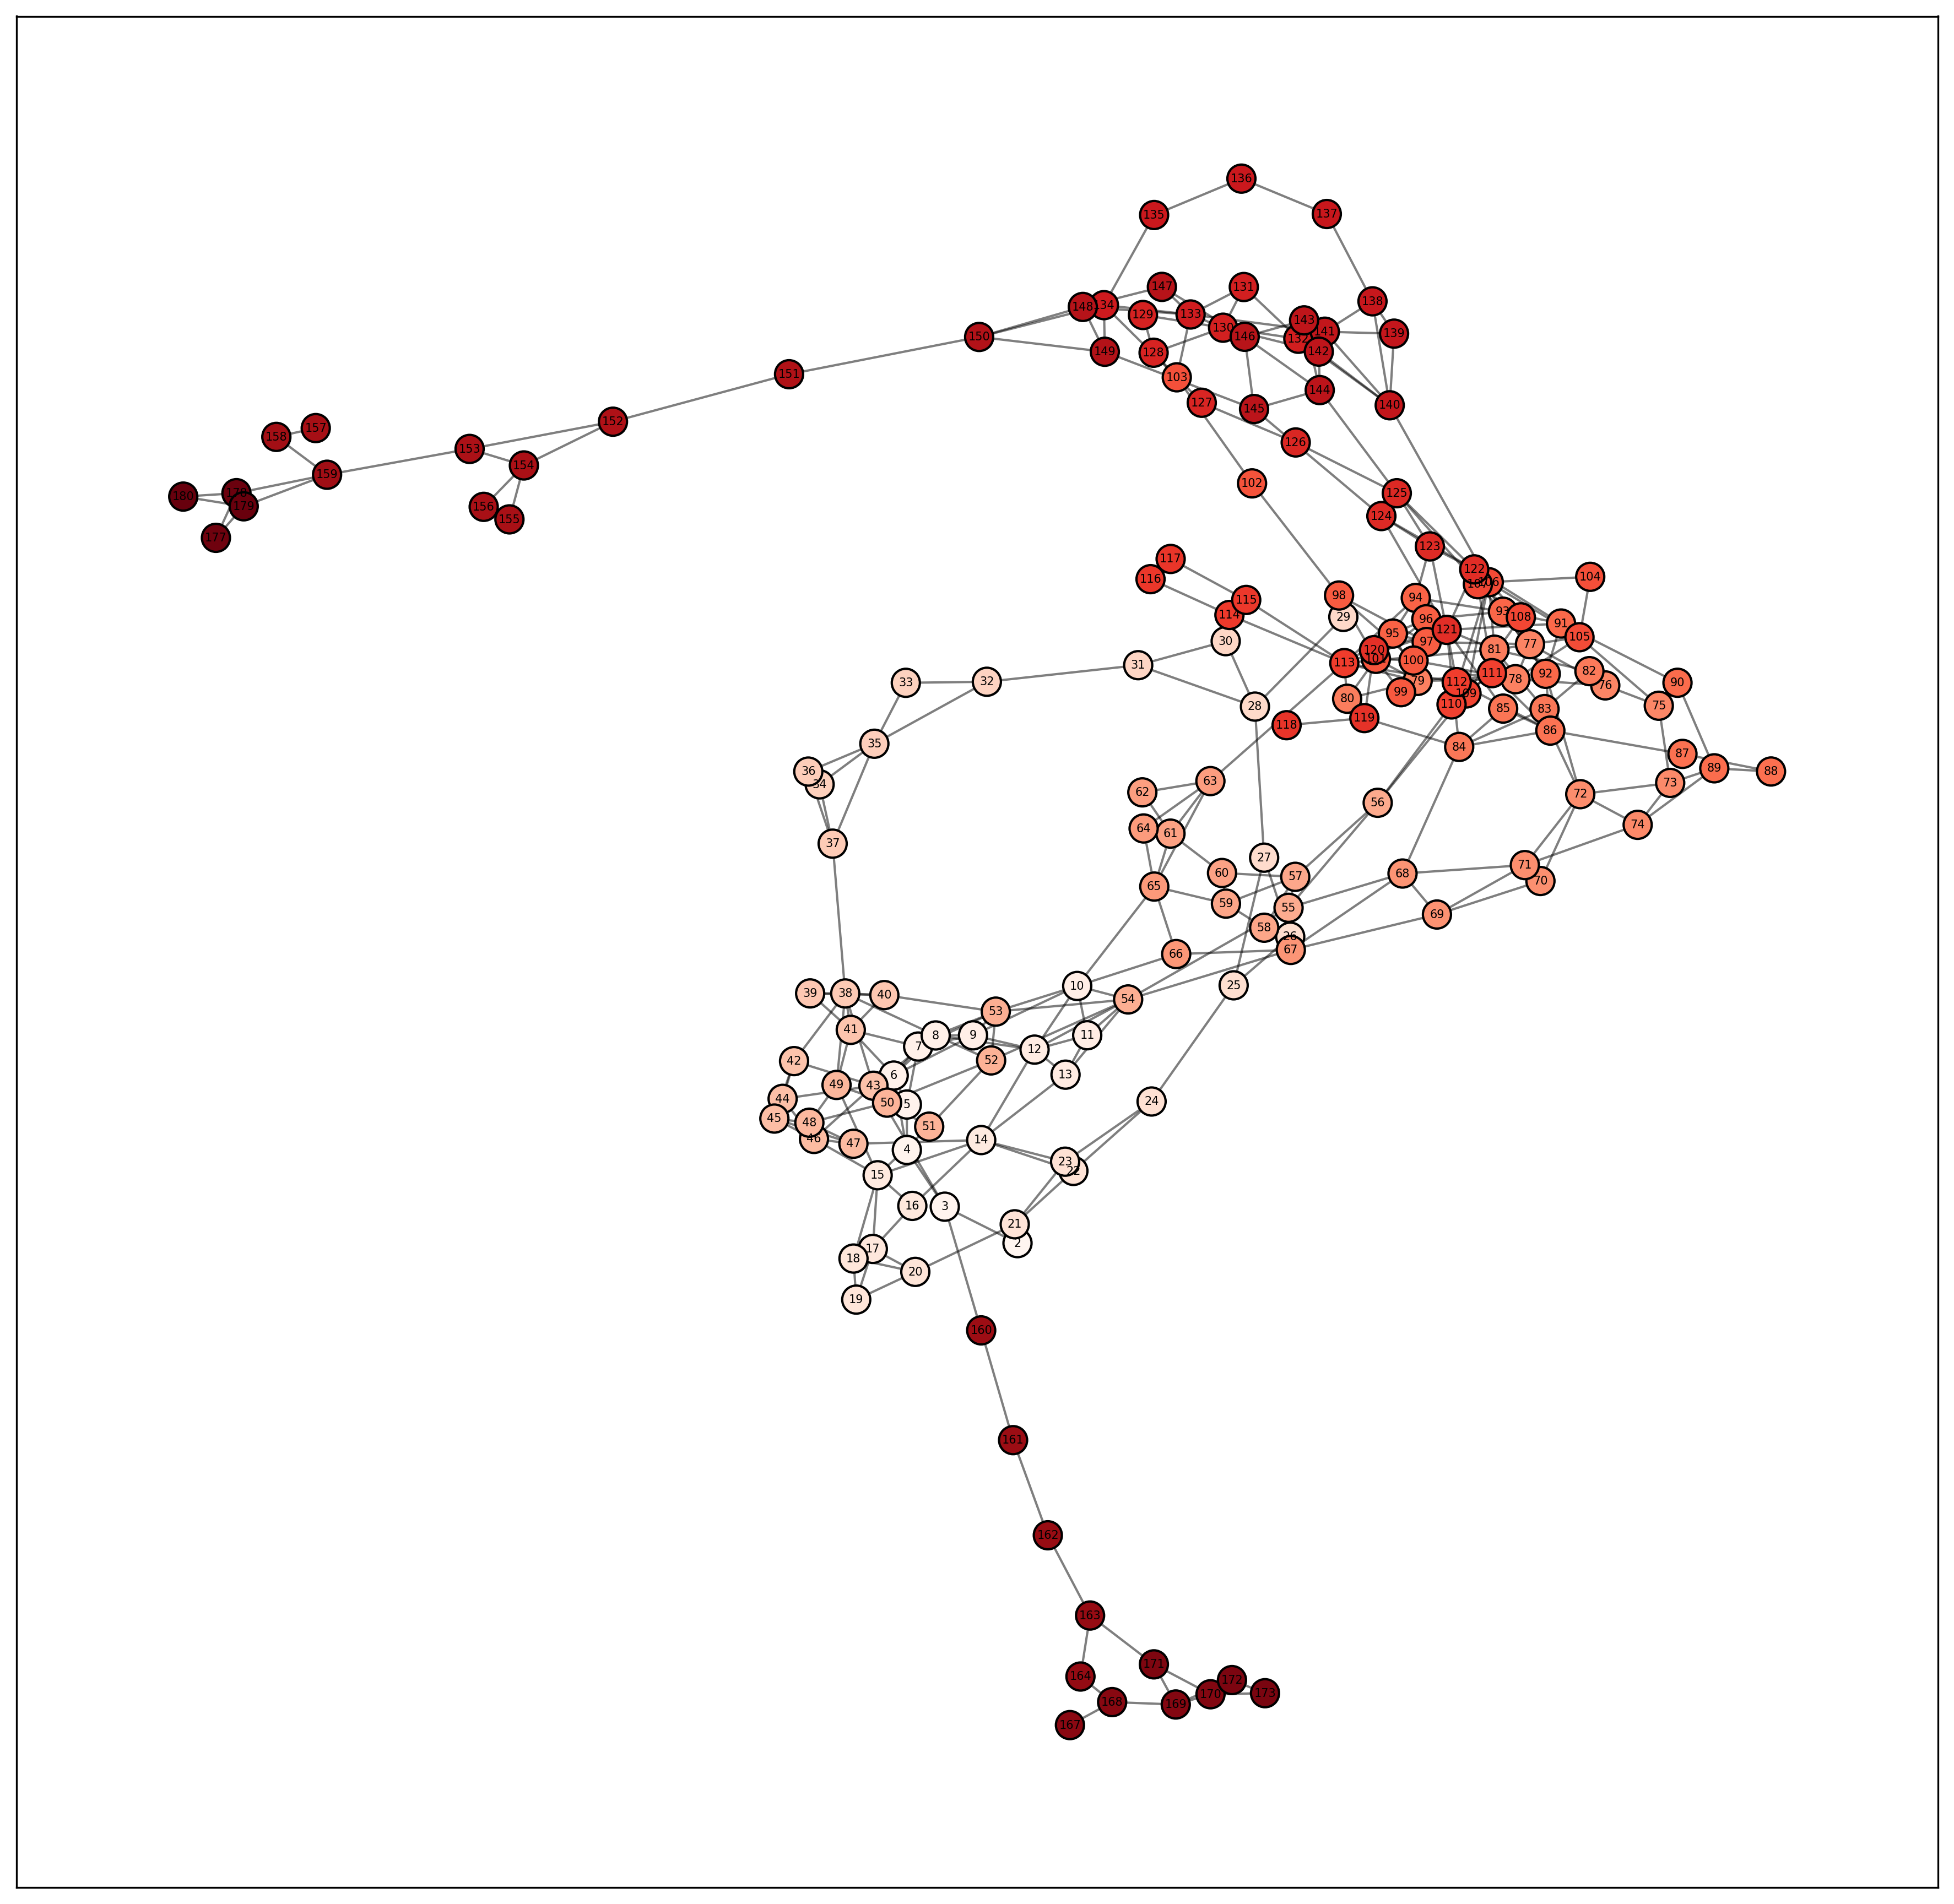

In [221]:
plt.rcParams['figure.facecolor'] = 'white'

componentThreshold = 3

def removeDisconnectedComponents(G, threhsold):
   # remove disconnected components
    for component in list(nx.connected_components(G)):
        if len(component) < threhsold:
            for node in component:
                G.remove_node(node)
    return G

                
cmap = 'Reds'

for runId, A in matrices.items():
    
    # remove self-loops for cleaner graph
    A = A - np.diag(np.diag(A))
    
    G = nx.from_numpy_array(A)
    
    G = removeDisconnectedComponents(G, componentThreshold)
    
    G.pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, 
                           pos=G.pos,
                           node_size=150,
                           node_color = G.nodes,
                           edgecolors = 'k',
                           alpha=1,
                           cmap=cmap)
    
    nx.draw_networkx_labels(G, 
                        pos=G.pos,
                        font_size=5
                       )
    
    nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=1,
                       alpha=0.5)
    
    
    break
    

In [207]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 15, 15
# plt.rcParams['figure.facecolor'] = 'white'

# cmap = 'viridis'

# for runId, A in matrices.items():
    
#     A = A - np.diag(np.diag(A))
    
#     print(f"{A.max()}")
    
#     G = nx.from_numpy_array(A)
    
#     G.pos = nx.circular_layout(G)
    
#     # draw the network - more control if you draw nodes and edges separately 
#     nx.draw_networkx_nodes(G,
#                            pos=G.pos,
#                            node_size=150,
#                            node_color = G.nodes,
#                            edgecolors = 'k',
#                            alpha=0.2,
#                            cmap=cmap
#                           )
    
#     nx.draw_networkx_labels(G, 
#                             pos=G.pos,
#                             font_size=5
#                            )
    
#     nx.draw_networkx_edges(G,
#                            pos=G.pos,
#                            width=1,
#                            alpha=0.5
#                           )
    

    
#     break

1.0
{10: {'weight': 1.0}, 12: {'weight': 1.0}, 13: {'weight': 1.0}, 54: {'weight': 1.0}}
